# MET Trigger Efficiency Study Example
---

The trigger efficiency study is setup in two step. The first step is a cutflow-styled analyzer that applies successive cuts and then takes a snapshot of all the booked histograms. The second step is to dump those histograms into a `TGraphAsymmErrors` or `TEfficiency` and plot efficiency curves. And since there are histograms for each successive selection, the evolution of the numerator and denominator distributions can be investigated.

## 1. Submitting Analyzer Jobs
---

In [1]:
import os

from efficiency_analyzer import EfficiencyAnalyzer

In [2]:
# The cuts to apply. This also determines the directory structure within
# the output ROOT file. Aside from the "NoCuts" directory, there will also
# be directories "Cut1", "Cut2", ..., "CutN", where N is the number of cuts.
# The numbering scheme follows the order the cuts are provided in the list.
cuts = [
    'Vtype == 3',
    'nJet >= 2 && Sum$(Jet_Pt > 20 && abs(Jet_eta) < 2.5 && Jet_lepFilter) >= 2',
    'HLT_Ele27_WPTight_Gsf',
    'abs(TVector2::Phi_mpi_pi(Electron_phi[0] - MET_phi)) < 2.5',
    'Flag_goodVertices && Flag_globalSuperTightHalo2016Filter && Flag_HBHENoiseFilter && Flag_HBHENoiseIsoFilter && Flag_EcalDeadCellTriggerPrimitiveFilter && Flag_BadPFMuonFilter && Flag_BadChargedCandidateFilter && Flag_eeBadScFilter',
    'HLT_PFMET140_PFMHT140_IDTight',
]

In [3]:
# The histograms to save. The tuples specify the name of the histogram (which should
# be unique at the directory level), the expression defining the histogrammed quantity,
# the number of bins along the x-axis, the value of the lower edge of the first bin,
# and the value of the upper edge of the last bin, respectively.
histograms = [
    ('RawMET', 'RawMET_pt', 50, 0, 500),
    ('MET', 'MET_pt', 50, 0, 500),
    ('TkMET', 'TkMET_pt', 50, 0, 500),
    ('PuppiMET', 'PuppiMET_pt', 50, 0, 500),
    ('MHT', 'MHT_pt', 50, 0, 500),
    ('minMETMHT', 'min(MET_pt, MHT_pt)', 50, 0, 500),
    ('Vtype', 'Vtype', 7, -1, 6),
    ('Jet1Pt', 'Jet_Pt[0]', 50, 0, 500),
    ('Jet2Pt', 'Jet_Pt[1]', 50, 0, 500),
    ('Jet1Eta', 'Jet_eta[0]', 100, -5, 5),
    ('Jet2Eta', 'Jet_eta[1]', 100, -5, 5),
    ('Jet1CMVA', 'Jet_btagCMVA[0]', 100, -1, 1),
    ('Jet2CMVA', 'Jet_btagCMVA[1]', 100, -1, 1),
    ('absDeltaPhiJetMET', 'MinIf$(abs(TVector2::Phi_mpi_pi(Jet_phi - MET_phi)), Jet_pt > 30 && Jet_puId > 0)', 32, 0, 3.2),
]

In [4]:
# Create an instance of the job submission interface.
analyzer = EfficiencyAnalyzer()

# Calling the submit method submits a job.
analyzer.submit(
    # The name of the directory containing job submission files, log files useful
    # for debugging, and the output files. Because of the small size of the output
    # files, it's safe to have HTCondor handle their transfer from the execution node
    # for convenience. They are stored within the job directory within a subdirectory
    # named "outputs".
    name='SingleElectron2017',
    # The source argument can be a fully qualified dataset name of the form 
    # "/primary_dataset/processed_dataset/data_tier", in which case you'll
    # need to also pass the dbs_instance argument and maybe the xrootd_redirector
    # argument if you need to use a something other than the CMS global redircetor.
    # All logical filenames associated with that dataset will be analyzed.
    #
    # The source argument can also be a plain XRootD url, at which point you can
    # ignore the dbs_instance and xrootd_redirector arguments. If the url is a
    # directory, it is recursively searched for ROOT files. All located ROOT files
    # will be analyzed.
    src='/SingleElectron/scoopers-RunIISummer17MiniAOD-92X-VHbbPostNano2017_V1-e70630e8aef2c186cd650f6150c31168/USER',
    dbs_instance='phys03',
    # The cuts and histograms that configure the analyzer.
    cuts=cuts,
    histograms=histograms,
    # Any additonal HTCondor job commands. Since we are accessing files scattered
    # across various grid sites, we also pass our grid proxy to the jobs.
    # Clearly, the proxy will have to be valid and the environment variable
    # "X509_USER_PROXY" should be set to the absolute path of the proxy file.
    commands={
        'x509userproxy': os.environ['X509_USER_PROXY']
    },
)

## 2. Creating Efficiency Histograms
---

In [2]:
!hadd -f SingleElectron2017.root EfficiencyAnalyzerJobs/SingleElectron2017/outputs/*.root

hadd Target file: SingleElectron2017.root
hadd compression setting for all ouput: 1
hadd Source file 1: EfficiencyAnalyzerJobs/SingleElectron2017/job1.root
hadd Source file 2: EfficiencyAnalyzerJobs/SingleElectron2017/job10.root
hadd Source file 3: EfficiencyAnalyzerJobs/SingleElectron2017/job100.root
hadd Source file 4: EfficiencyAnalyzerJobs/SingleElectron2017/job101.root
hadd Source file 5: EfficiencyAnalyzerJobs/SingleElectron2017/job102.root
hadd Source file 6: EfficiencyAnalyzerJobs/SingleElectron2017/job103.root
hadd Source file 7: EfficiencyAnalyzerJobs/SingleElectron2017/job104.root
hadd Source file 8: EfficiencyAnalyzerJobs/SingleElectron2017/job105.root
hadd Source file 9: EfficiencyAnalyzerJobs/SingleElectron2017/job106.root
hadd Source file 10: EfficiencyAnalyzerJobs/SingleElectron2017/job107.root
hadd Source file 11: EfficiencyAnalyzerJobs/SingleElectron2017/job108.root
hadd Source file 12: EfficiencyAnalyzerJobs/SingleElectron2017/job109.root
hadd Source file 13: Efficie

In [4]:
import ROOT

def load_histograms():
    """Load all of the histograms into memory and organize them inside a dictionary of
    dictionaries. The outer dictionary key the name of a subdirectory to its histograms.
    The inner dictionaries key the name of the histograms to the actual histogram objects.
    """
    histograms = {}
    f = ROOT.TFile.Open('SingleElectron2017.root')
    for key in f.GetListOfKeys():
        subdir = key.ReadObj()
        histograms[subdir.GetName()] = {key.GetName(): key.ReadObj() for key in subdir.GetListOfKeys()}
    for _, histdict in histograms.iteritems():
        for _, histogram in histdict.iteritems():
            histogram.SetDirectory(0)
    f.Close()
    return histograms

HISTOGRAMS = load_histograms()

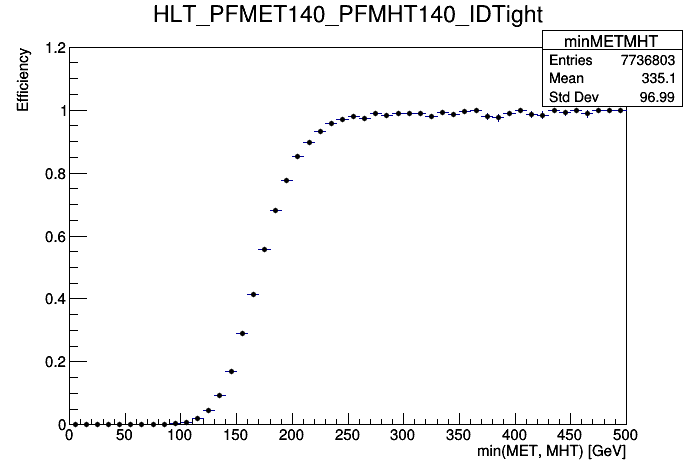

In [9]:
# This isn't the right way to do it, you really should pass it to TEfficiency
# or at least to TGraphAsymmErrors, but this should give you an idea of what to do.
denominator = HISTOGRAMS['Cut5']['minMETMHT'].Clone()
efficiency = HISTOGRAMS['Cut6']['minMETMHT'].Clone()
efficiency.Divide(efficiency, denominator, 1, 1, 'B')
efficiency.SetMinimum(0)
efficiency.SetMaximum(1.2)
efficiency.SetMarkerStyle(20)
efficiency.SetMarkerSize(0.5)
efficiency.SetTitle('HLT_PFMET140_PFMHT140_IDTight')
efficiency.SetXTitle('min(MET, MHT) [GeV]')
efficiency.SetYTitle('Efficiency')

c = ROOT.TCanvas()
efficiency.Draw('E0')
c.Draw()